In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Data Preprocessing
Locate files:

C = Cuivre / Copper / Cu
Z = Zinc / Zn
M = Methomyl

In [21]:
def extract_substances(dataframe):
    # Get the column names from the DataFrame
    columns = dataframe.columns

    # Create a dictionary to store the count of each unique substance
    substance_counts = {}

    # Extract unique substances from the column names and count occurrences
    for column in columns:
        # Split the column name based on the numeric part
        substance = ''.join([i for i in column if not i.isdigit()])
        
        # Update the count in the dictionary
        substance_counts[substance] = substance_counts.get(substance, 0) + 1

    # Convert the dictionary to two lists (substances and counts) and sort them
    unique_substances_list = sorted(list(substance_counts.keys()))
    counts_list = [substance_counts[substance] for substance in unique_substances_list]

    return unique_substances_list,counts_list

### FPCA for individual species

In [11]:
#define parameters
specie = {'E':'Erpobdella','G':'Gammarus','R':'Radix'}
specie_dim = {'E':'X','G':'Y','R':'Z'}

In [12]:
#locate files and load data for each species
directory = r'D:\VP\ARTICLE2\ArticleData'
data = {s:pd.read_csv(r'{}\{}_{}_i_data.csv'.format(directory,s,specie_dim[s])) for s in specie}

In [13]:
data['E'].head()

,Copper0,Copper1,Copper2,Copper3,Copper4,Copper5,Copper6,Copper7,Methomyl0,Methomyl1,...,Methomyl4,Methomyl5,Methomyl6,Verapamil0,Verapamil1,Verapamil2,Zinc0,Zinc1,Zinc2,Zinc3
0,0.000000,0.009945,0.007600,0.004918,0.003527,0.136334,0.0,0.033721,0.0,0.0,...,0.0,0.019985,0.0,0.004411,0.0,0.012995,0.014192,0.017863,0.019961,0.052168
1,0.003304,0.012224,0.007415,0.004241,0.003536,0.133719,0.0,0.028350,0.0,0.0,...,0.0,0.018707,0.0,0.004098,0.0,0.012568,0.025258,0.020955,0.025910,0.056082
2,0.000000,0.010322,0.007105,0.003829,0.003451,0.132936,0.0,0.023312,0.0,0.0,...,0.0,0.017764,0.0,0.003722,0.0,0.011686,0.030188,0.025255,0.029043,0.061203
3,0.000000,0.008777,0.006848,0.003865,0.003303,0.131513,0.0,0.020177,0.0,0.0,...,0.0,0.016792,0.0,0.003335,0.0,0.010044,0.028381,0.029273,0.028291,0.064987
4,0.000000,0.007777,0.007013,0.004321,0.005174,0.131278,0.0,0.017711,0.0,0.0,...,0.0,0.015747,0.0,0.004352,0.0,0.009980,0.025710,0.023732,0.028286,0.069752


In [22]:
#identify all used substances
substances,counts = extract_substances(data[[*data][0]])
substances,counts

(['Copper', 'Methomyl', 'Verapamil', 'Zinc'], [8, 7, 3, 4])

In [25]:
#Define columns and y values for functional data analysis
cols = data[[*data][0]].columns
y = ['{}'.format(s) for i,s in enumerate(substances) for x in range(counts[i])]
y

['Copper',
 'Copper',
 'Copper',
 'Copper',
 'Copper',
 'Copper',
 'Copper',
 'Copper',
 'Methomyl',
 'Methomyl',
 'Methomyl',
 'Methomyl',
 'Methomyl',
 'Methomyl',
 'Methomyl',
 'Verapamil',
 'Verapamil',
 'Verapamil',
 'Zinc',
 'Zinc',
 'Zinc',
 'Zinc']

### Import relevant Data Structures and convert to FD Data Grids and BSplines

In [26]:
from skfda.representation.grid import FDataGrid
from skfda.representation.basis import BSplineBasis

In [27]:
#Define timestep for data and remove end data
timestep = 30
full_length = data[[*data][0]].shape[0]
n_rows = (full_length//timestep)*timestep

In [28]:
#define FDA parameters
domain_range = (0,n_rows)
order = 4
knots = np.arange(0,n_rows+timestep,timestep)
n_basis = len(knots) + order - 2

bbs = BSplineBasis(domain_range = domain_range,n_basis = n_basis,order = order,knots = knots)
knots

array([  0,  30,  60,  90, 120, 150, 180, 210, 240, 270, 300, 330, 360,
       390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720])

In [29]:
grid_points = np.arange(n_rows)
data_matrices = {s:np.transpose(np.array(data[s].iloc[:n_rows])) for s in specie}

fds = {s:FDataGrid(data_matrix=data_matrices[s],grid_points=grid_points,) for s in specie}

### Create basis functions

In [30]:
bss = BSplineBasis(domain_range = domain_range,n_basis = n_basis,order = order,knots = knots)

In [31]:
X_bss = {s:fds[s].to_basis(bss) for s in specie}

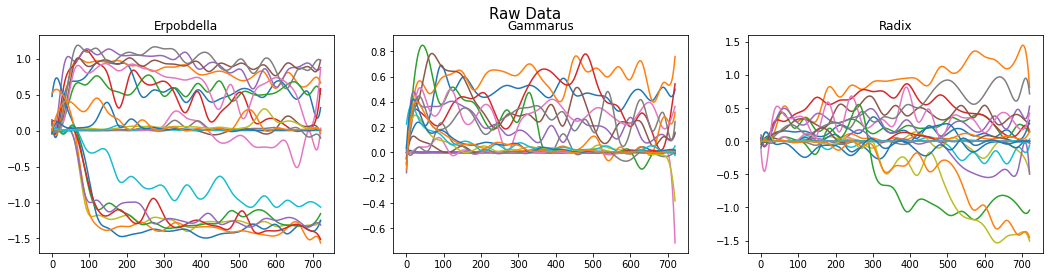

In [32]:
fig,axe = plt.subplots(1,3,figsize = (18,4))
fig.suptitle('Raw Data',fontsize = 15)
for i,s in enumerate(specie): 
    X_bss[s].plot(axes = axe[i])
    axe[i].set_title(specie[s])

## FPCA

In [33]:
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA

In [34]:
fpcas = {s: FPCA(n_components=2).fit(X_bss[s]) for s in specie}

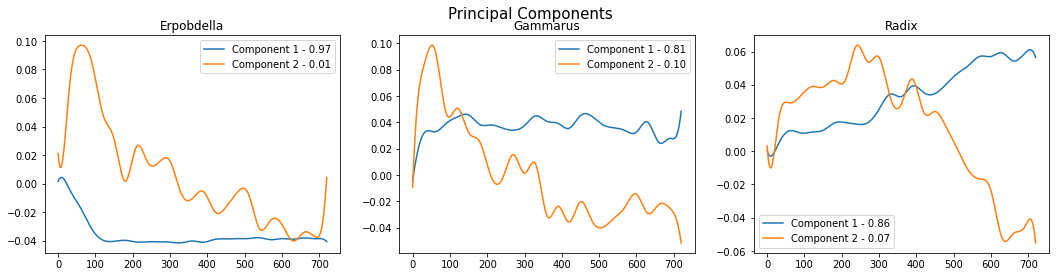

In [35]:
fig,axe = plt.subplots(1,3,figsize = (18,4))
fig.suptitle('Principal Components',fontsize = 15)
for i,s in enumerate(specie):
    fpcas[s].components_.plot(axes = axe[i])
    axe[i].legend(
        labels=['Component 1 - {:.2f}'.format(fpcas[s].explained_variance_ratio_[0]),
                'Component 2 - {:.2f}'.format(fpcas[s].explained_variance_ratio_[1])])
    axe[i].set_title(specie[s])

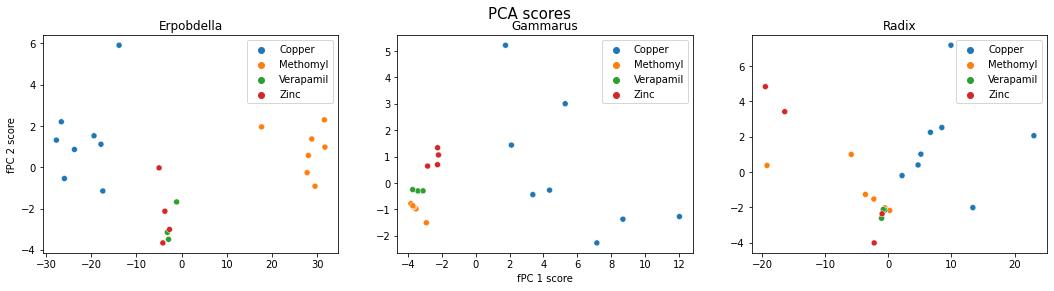

In [36]:
#Show all PCAs as FPCA scores plot
scores = {s:fpcas[s].fit_transform(X_bss[s]) for s in specie}

fig_FPCA,ax_FPCA = plt.subplots(1,3,figsize=(18,4))
fig_FPCA.suptitle('PCA scores',fontsize = 15)

ax_FPCA[1].set_xlabel("fPC 1 score")
ax_FPCA[0].set_ylabel("fPC 2 score")

for i,s in enumerate(specie):
    sns.scatterplot(x=scores[s][:, 0], y=scores[s][:, 1],hue = y,ax = ax_FPCA[i])
    ax_FPCA[i].set_title(specie[s])  

#ax_meanFPCA.tick_params(labelsize = 13)
plt.show()

## MultiVector FDA

Whilst this is possible to create multidimensional Vector grids, their combination has not yet been achieved.

In [37]:
from skfda.representation.basis import VectorValuedBasis

In [38]:
data_vector_matrix = np.transpose(np.array([np.array(data[s].iloc[:n_rows]) for s in specie]))
vector_fd = FDataGrid(data_matrix=data_vector_matrix,grid_points=grid_points,)

In [39]:
vector_bss = VectorValuedBasis([bss for i in range(3)])
vector_bss = vector_fd.to_basis(vector_bss)

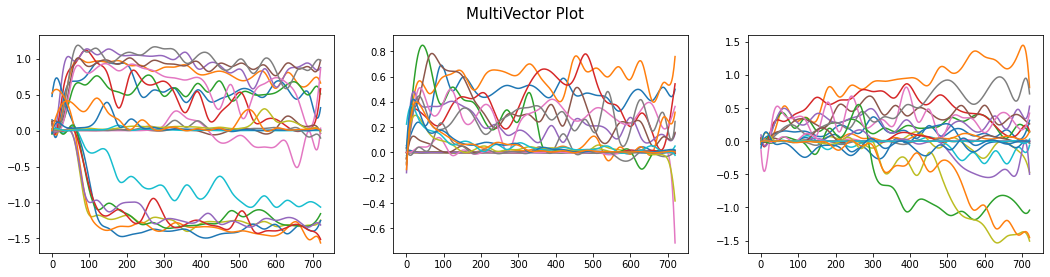

In [40]:
fig,axe = plt.subplots(1,3,figsize = (18,4))
fig.suptitle('MultiVector Plot',fontsize = 15)
vector_bss.plot(axes = axe)
plt.show()

### What appears strange here is there is not exactly the same PCA for each domain 

Perhaps there is some kind of normalisation

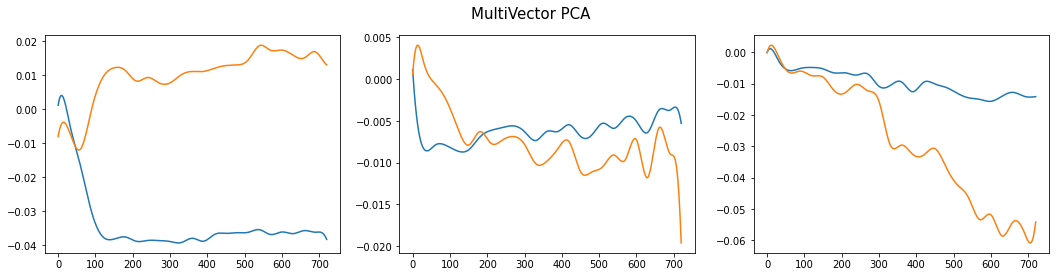

In [41]:
fig,axe = plt.subplots(1,3,figsize = (18,4))
fig.suptitle('MultiVector PCA',fontsize = 15)
vector_fpca = FPCA(n_components=2).fit(vector_bss)
vector_fpca.components_.plot(axes = axe)
plt.show()

In [42]:
### Failed PCA plot attempt
scores = vector_fpca.fit_transform(vector_bss)
scores

array([[-1.88956055e+01,  1.40454438e+00],
       [-3.08733145e+01, -1.65762395e+01],
       [-1.82424053e+01,  1.11162167e+00],
       [-1.73118749e+01, -6.75249720e+00],
       [-2.70740032e+01,  2.69821622e+00],
       [-2.79352970e+01, -6.21994378e-01],
       [-2.10148125e+01, -1.25944794e+00],
       [-3.03697582e+01, -5.13399836e+00],
       [ 2.92325837e+01, -6.14436069e+00],
       [ 1.84273159e+01, -1.61673000e+00],
       [ 3.09088162e+01, -8.34416570e+00],
       [ 3.05344171e+01, -9.63364723e+00],
       [ 3.24294998e+01,  9.93561232e+00],
       [ 2.80943320e+01, -7.80825436e+00],
       [ 2.84963928e+01, -2.19432099e+00],
       [-1.89011697e+00,  2.31124714e+00],
       [-9.45499940e-02,  1.78877149e+00],
       [-2.02572711e+00,  2.71272274e+00],
       [ 1.73152580e+00,  2.05384524e+01],
       [-1.78363824e+00,  2.43658283e+00],
       [-2.35603209e+00,  3.72902621e+00],
       [ 1.22521192e-02,  1.74188589e+01]])

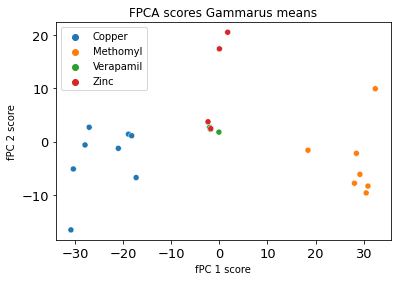

In [43]:
fig_vector_FPCA,ax_vector_FPCA = plt.subplots(figsize=(6, 4))
sns.scatterplot(x=scores[:, 0], y=scores[:, 1],hue = y,ax = ax_vector_FPCA)
ax_vector_FPCA.set_xlabel("fPC 1 score")
ax_vector_FPCA.set_ylabel("fPC 2 score")
ax_vector_FPCA.set_title("FPCA scores Gammarus means")

ax_vector_FPCA.tick_params(labelsize = 13)
plt.show()

# Clustering

**Clustering methods should be fed the smoothed data not the basis data - it must be loaded in**

In [44]:
from skfda.exploratory.visualization.clustering import (
    ClusterMembershipLinesPlot,
    ClusterMembershipPlot,
    ClusterPlot
)
from skfda.ml.clustering import FuzzyCMeans,KMeans

## Single basis clusters

In [45]:
#Clustering unsupervised (except no. clusters)
n_clusters = 4
seed = 0

kmeans = {s:KMeans(n_clusters = n_clusters, random_state = seed).fit(X_bss[s].to_grid()) for s in specie}
for s in specie:
    print('Kmeans prediction: {}'.format(specie[s]))
    print(kmeans[s].predict(X_bss[s].to_grid()))

Kmeans prediction: Erpobdella
[0 0 0 0 0 0 0 0 3 2 1 1 3 3 3 0 0 0 0 0 0 0]
Kmeans prediction: Gammarus
[0 0 1 0 1 1 0 0 3 3 3 3 3 3 3 3 3 3 2 2 2 2]
Kmeans prediction: Radix
[0 3 3 3 3 3 3 3 1 1 1 0 2 0 1 0 0 0 2 0 0 2]


In [46]:
vector_kmean = KMeans(n_clusters = 3, random_state = seed).fit(vector_bss.to_grid())
vector_kmean.predict(vector_bss.to_grid())

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0])